# Recurrent Neural Network

In [98]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


def union(df1, df2):
    return pd.concat([df1, df2]).drop_duplicates().reset_index(drop=True)


def load_data(column, batch_size):
    # Load data
    train = pd.read_csv("Google_Stock_Price_Train.csv", parse_dates=["Date"], thousands=',')
    test = pd.read_csv("Google_Stock_Price_Test.csv", parse_dates=["Date"], thousands=',')

    # Merge training and testing and apply one hot encoding
    data = union(train, test)
    # Add month and day
    data["month"] = pd.DatetimeIndex(data["Date"]).month
    data["day"] = pd.DatetimeIndex(data["Date"]).day
    data = pd.get_dummies(data, columns=["month", "day"]).drop(columns=["Date"])

    # Apply min-max scaler
    scaler = MinMaxScaler()
    scaler.fit(data)
    data = pd.DataFrame(scaler.transform(data), columns=data.columns)
    data = data.iloc[565:]
    
    y = data[column].to_numpy()
    X = data.drop(columns=column).to_numpy()
    features = X.shape[1]

    # Split training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=360, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

    # Convert to tensor
    X_train = torch.Tensor(X_train)
    y_train = torch.Tensor(y_train)
    X_test = torch.Tensor(X_test)
    y_test = torch.Tensor(y_test)
    X_val = torch.Tensor(X_val)
    y_val = torch.Tensor(y_val)

    train = TensorDataset(X_train, y_train)
    test = TensorDataset(X_test, y_test)
    val = TensorDataset(X_val, y_val)

    trainloader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
    testloader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
    valloader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)

    return trainloader, testloader, valloader, features

In [99]:
import torch.nn as nn
import torch.nn.functional as F


def get_model(model, **args):
    if model == "rnn":
        return RNN(**args)
    elif model == "lstm":
        return LSTM(**args)
    elif model == "gru":
        return GRU(**args)

In [100]:
class RNN(nn.Module):
    def __init__(self, hidden_dim, layer_dim, features, dropout):
        super(RNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.dropout = dropout
        self.output_dim = 1

        self.rnn = nn.RNN(features, self.hidden_dim, self.layer_dim, batch_first=True, dropout=dropout)

        self.fc = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [101]:
class LSTM(nn.Module):
    def __init__(self, hidden_dim, layer_dim, features, dropout):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.dropout = dropout
        self.output_dim = 1

        self.rnn = nn.LSTM(features, self.hidden_dim, self.layer_dim, batch_first=True, dropout=dropout)

        self.fc = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, (hn, cn) = self.rnn(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [102]:
class GRU(nn.Module):
    def __init__(self, hidden_dim, layer_dim, features, dropout):
        super(GRU, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.dropout = dropout
        self.output_dim = 1

        self.rnn = nn.GRU(features, self.hidden_dim, self.layer_dim, batch_first=True, dropout=dropout)

        self.fc = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [103]:
import numpy as np
import matplotlib.pyplot as plt


def fit(rnn, trainloader, testloader, valloader, batch_size, criterion, optimizer, features):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # device = torch.device("cpu")
    rnn.to(device)
    epoch_num = 200
    min_val = 1000
    n = 0
    train_losses = []
    val_losses = []
    for epoch in range(1, epoch_num + 1):  # loop over the dataset multiple times
        batch_losses = []
        for inputs, labels in trainloader:
            # get the inputs; data is a list of [inputs, labels]
            inputs = inputs.view([batch_size, -1, features]).to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            rnn.train()
            outputs = rnn(inputs)
            loss = criterion(labels, outputs)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        train_losses.append(np.mean(batch_losses))

        # Validation loss
        with torch.no_grad():
            batch_val_losses = []
            for inputs, labels in valloader:
                # get the inputs; data is a list of [inputs, labels]
                inputs = inputs.view([batch_size, -1, features]).to(device)
                labels = labels.to(device)

                # forward + backward + optimize
                rnn.eval()
                outputs = rnn(inputs)
                loss = criterion(labels, outputs)
                batch_val_losses.append(loss.item())

            val_losses.append(np.mean(batch_val_losses))

        if np.mean(batch_val_losses) < min_val:
            min_val = np.mean(batch_val_losses)
            n = 0
        else:
            n += 1
        if n == 200:
            #print(f"Epoch: {epoch}  Training Error: {np.mean(batch_losses):.4f}  Validation Error: {np.mean(batch_val_losses):.4f}")
            break

        if epoch % 1 == 0:
            print(f"Epoch: {epoch}  Training Error: {np.mean(batch_losses):.4f}  Validation Error: {np.mean(batch_val_losses):.4f}")
    
    plt.yscale("log")
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.title("Training and validation error of GRU")
    plt.legend(["Training Error", "Validation Error"])
    #plt.savefig('error', dpi=600)

    

    train_prediction = []
    train_actual = []
    test_prediction = []
    test_actual = []
    for inputs, labels in trainloader:
        # get the inputs; data is a list of [inputs, labels]
        inputs = inputs.view([batch_size, -1, features]).to(device)
        labels = labels.to(device)
        
        rnn.eval()
        outputs = rnn(inputs)
        train_prediction.append(outputs.detach().numpy())
        train_actual.append(labels.detach().numpy())

    for inputs, labels in testloader:
        # get the inputs; data is a list of [inputs, labels]
        inputs = inputs.view([batch_size, -1, features]).to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        rnn.eval()
        outputs = rnn(inputs)
        test_prediction.append(outputs.detach().numpy())
        test_actual.append(labels.detach().numpy())

    train_prediction = np.array(train_prediction).flatten()
    train_actual = np.array(train_actual).flatten()
    test_prediction = np.array(test_prediction).flatten()
    test_actual = np.array(test_actual).flatten()

    return train_prediction, train_actual, test_prediction, test_actual


In [104]:
import seaborn as sns
sns.set()

def plot(prediction, actual):
    df = pd.DataFrame({"Predicted": prediction, "Actual": actual})
    sns.lineplot(data=df)

In [105]:
from sklearn.metrics import mean_squared_error, r2_score

def metrics(prediction, actual):
    r2 = r2_score(actual, prediction)
    rmse = mean_squared_error(actual, prediction, squared=False)

    print(f"R-squared: {r2:.4f}")
    print(f"Mean Square Error: {rmse:.4f}")
    return r2, rmse

C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0016  Validation Error: 0.0102
Epoch: 2  Training Error: 0.0010  Validation Error: 0.0115
Epoch: 3  Training Error: 0.0010  Validation Error: 0.0113
Epoch: 4  Training Error: 0.0009  Validation Error: 0.0106
Epoch: 5  Training Error: 0.0009  Validation Error: 0.0102
Epoch: 6  Training Error: 0.0008  Validation Error: 0.0097
Epoch: 7  Training Error: 0.0007  Validation Error: 0.0090
Epoch: 8  Training Error: 0.0006  Validation Error: 0.0084
Epoch: 9  Training Error: 0.0006  Validation Error: 0.0076
Epoch: 10  Training Error: 0.0005  Validation Error: 0.0071
Epoch: 11  Training Error: 0.0005  Validation Error: 0.0065
Epoch: 12  Training Error: 0.0004  Validation Error: 0.0065
Epoch: 13  Training Error: 0.0004  Validation Error: 0.0063
Epoch: 14  Training Error: 0.0004  Validation Error: 0.0062
Epoch: 15  Training Error: 0.0004  Validation Error: 0.0063
Epoch: 16  Training Error: 0.0004  Validation Error: 0.0062
Epoch: 17  Training Error: 0.0004  Validation Err

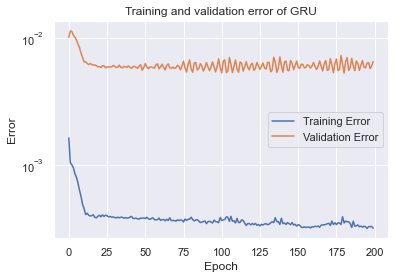

In [106]:
import torch.optim as optim
column = "Close"
batch_size = 20

trainloader, testloader, valloader, features = load_data(column, batch_size)

# RNN hyperparamters
params = {"hidden_dim": 50,
        "layer_dim": 2,
        "dropout": 0.2,
        "features": features}

# rnn, lstm, gru
model = "lstm"
rnn = get_model(model, **params)

criterion = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(rnn.parameters(), lr=0.001)

args = {"batch_size": batch_size,
        "trainloader": trainloader,
        "testloader": testloader,
        "valloader": valloader,
        "features": features,
        "rnn": rnn,
        "criterion": criterion,
        "optimizer": optimizer}

train_prediction, train_actual, test_prediction, test_actual = fit(**args)
r2, rmse = metrics(test_prediction, test_actual)

R-squared: 0.7258
Mean Square Error: 0.0166


Text(0.5, 1.0, 'LSTM with hidden=20 and layer=1 with close as objective')

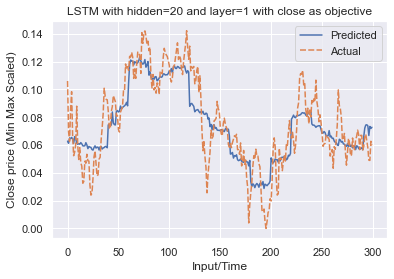

In [108]:
plot(train_prediction, train_actual)
metrics(train_prediction, train_actual)
plt.xlabel("Input/Time")
plt.ylabel("Close price (Min Max Scaled)")
plt.title("LSTM with hidden=20 and layer=1 with close as objective")
#plt.savefig('lstm_close', dpi=600)

R-squared: -13.2682
Mean Square Error: 0.2601


(-13.268244984400784, 0.2600647)

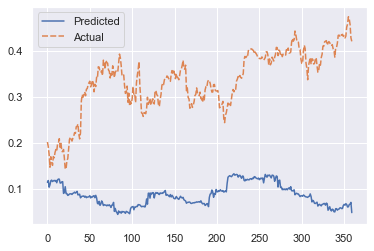

In [109]:
plot(test_prediction, test_actual)
metrics(test_prediction, test_actual)